### ODL - Group 1 : Binary Classification of Detecting Thyroid Disease

- Foo Lee Yi - TP054547
- Gun Ming Fai - TP056531
- Khor Zhen Win - TP055619
- Woon Eusean - TP055977


In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install scipy
%pip install keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Read Dataset


In [2]:
# set dataframe column display to show all columns
pd.set_option("display.max_columns", None)

In [3]:
df1 = pd.read_csv("dataset/thyroidDF.csv")
df2 = pd.read_csv("dataset/hypothyroid.csv")

In [4]:
df1.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [5]:
df2.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,P


### Data Preprocessing


#### Renaming Columns to Merge Dataframes


In [6]:
# normalize df2 column name to snake_case
df2.columns = df2.columns.str.replace(" ", "_")

In [7]:
# check if normalized
# print column difference of df2 and df1
print(set(df2.columns) - set(df1.columns))
print(set(df1.columns) - set(df2.columns))
print(len(set(df2.columns) - set(df1.columns)))

{'binaryClass', 'on_antithyroid_medication'}
{'patient_id', 'target', 'on_antithyroid_meds'}
2


In [8]:
# normalize on_antithyroid_medication -> on_antithyroid_meds
# drop patient_id in df1
df1.drop("patient_id", axis=1, inplace=True)
df2.rename(
    columns={"on_antithyroid_medication": "on_antithyroid_meds"}, inplace=True)

In [9]:
# number of columns in df1 and df2
print(len(df1.columns))
print(len(df2.columns))

30
30


#### Compacting Number of Levels in Target Variable


Letter Diagnosis For Target Variable

---

"-" FOR NO CONDITION - Group 0

**hyperthyroid conditions:** - Group 1

- A: hyperthyroid
- B: T3 toxic
- C: toxic goitre
- D: secondary toxic

**hypothyroid conditions:** - Group 2

- E: hypothyroid
- F: primary hypothyroid
- G: compensated hypothyroid
- H: secondary hypothyroid

**binding protein:** - Group 3

- I: increased binding protein
- J: decreased binding protein

**general health:** - Group 4

- K: concurrent non-thyroidal illness

**replacement therapy:** - Group 5

- L: consistent with replacement therapy
- M: underreplaced
- N: overreplaced

**antithyroid treatment:** - Group 6

- O: antithyroid drugs
- P: I131 treatment
- Q: surgery

**miscellaneous:** - Group 7

- R: discordant assay results
- S: elevated TBG
- T: elevated thyroid hormones


In [10]:

# grouping of target column based on grouped levels defined
# 0 - "-"
# 1 - A,B,C,D
# 2 - E,F,G,H
# 3 - I,J
# 4 - K
# 5 - L,M,N
# 6 - O,P,Q
# 7 - R,S,T

# define function to group target column
def group_target(x):
    # if x is anything but string, return 0
    if type(x) == int:
        return x
    # split x to get first character
    x = x[0]
    if x in ["A", "B", "C", "D"]:
        return 1
    elif x in ["E", "F", "G", "H"]:
        return 2
    elif x in ["I", "J"]:
        return 3
    elif x == "K":
        return 4
    elif x in ["L", "M", "N"]:
        return 5
    elif x in ["O", "P", "Q"]:
        return 6
    elif x in ["R", "S", "T"]:
        return 7
    else:
        return 0

<Axes: xlabel='target', ylabel='count'>

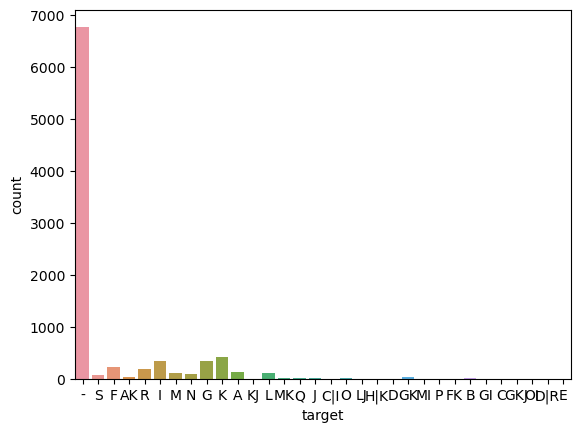

In [11]:
# plot barchart for distribution of "target" column
sns.countplot(x="target", data=df1)

In [12]:
# apply function to target column
df1["target"] = df1["target"].apply(group_target)
df1["target"].value_counts()

0    6771
2     667
4     447
3     376
5     355
7     281
1     241
6      34
Name: target, dtype: int64

##### Labelling Target Variable For Second Dataset To Merge


Since this dataset is specifically for hypothyroid conditions

- "P" in the binaryClass will fall under Group 2
- "N" in the binaryClass will fall under Group 0


<Axes: xlabel='binaryClass', ylabel='count'>

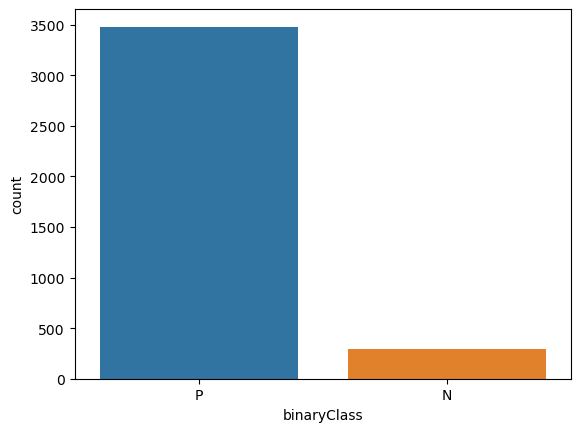

In [13]:
sns.countplot(x="binaryClass", data=df2)
# P - Positive Hypothyroid
# N - Negative Hypothyroid

In [14]:
# rename binaryClass to target and convert P to 2 and N to 0
df2.rename(columns={"binaryClass": "target"}, inplace=True)
df2["target"] = df2["target"].map({"P": 2, "N": 0})
df2["target"].value_counts()

2    3481
0     291
Name: target, dtype: int64

#### Merge Dataframes & Evaluate


In [16]:
# merge df1 and df2
df = pd.concat([df1, df2], axis=0)

In [17]:
print(df.shape)
df.head()

(12944, 30)


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,0
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,0
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,0
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,0
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,36.0,other,7


In [18]:
# check for new target distribution
df["target"].value_counts()

0    7062
2    4148
4     447
3     376
5     355
7     281
1     241
6      34
Name: target, dtype: int64